## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import ast
import seaborn as sns

from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import math, random
from sklearn.metrics import roc_auc_score, accuracy_score

# base path for data files
base_path = "./data/"
 
print(f"Working directory set to: {base_path}")

Working directory set to: ./data/


## EDA - Load Data & Compute Stats
PART 1: EXPLORATORY ANALYSIS

Sparsity: 0.000022


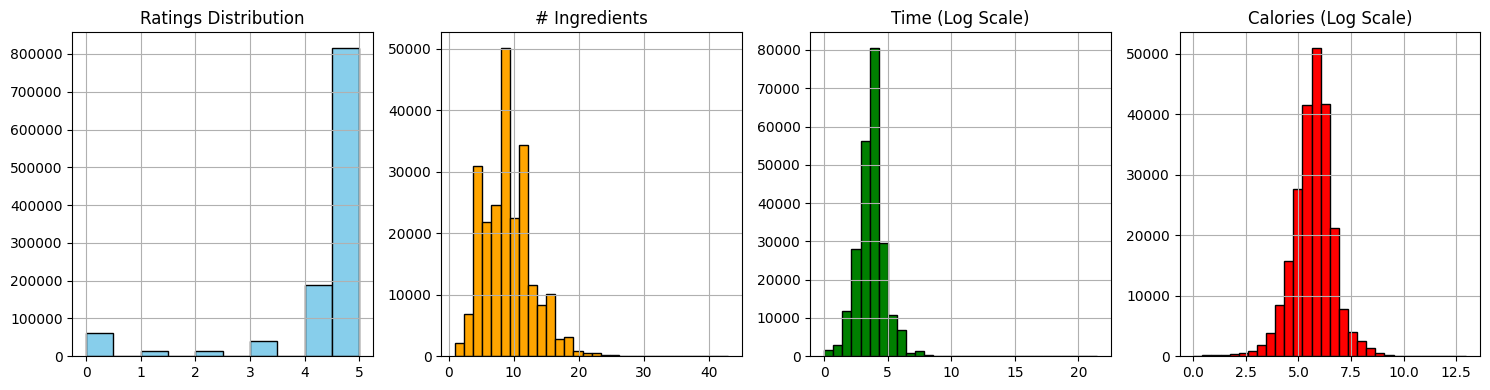

In [2]:
try:
    raw_inter_df = pd.read_csv(base_path + "RAW_interactions.csv")
    raw_recipes_df = pd.read_csv(base_path + "RAW_recipes.csv")

    num_users = raw_inter_df["user_id"].nunique()
    num_items = raw_inter_df["recipe_id"].nunique()
    sparsity = len(raw_inter_df) / (num_users * num_items)
    print(f"Sparsity: {sparsity:.6f}")
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 4, 1)
    raw_inter_df["rating"].hist(bins=10, color="skyblue", edgecolor="black")
    plt.title("Ratings Distribution")

    raw_recipes_df["n_ingredients"] = raw_recipes_df["n_ingredients"].fillna(0)
    raw_recipes_df["minutes"] = raw_recipes_df["minutes"].fillna(0)
    raw_recipes_df["calories"] = raw_recipes_df["nutrition"].apply(
        lambda x: float(ast.literal_eval(x)[0]) if isinstance(x, str) else 0
    )

    plt.subplot(1, 4, 2)
    raw_recipes_df["n_ingredients"].hist(bins=30, color="orange", edgecolor="black")
    plt.title("# Ingredients")

    plt.subplot(1, 4, 3)
    np.log1p(raw_recipes_df["minutes"]).hist(bins=30, color="green", edgecolor="black")
    plt.title("Time (Log Scale)")

    plt.subplot(1, 4, 4)
    np.log1p(raw_recipes_df["calories"]).hist(bins=30, color="red", edgecolor="black")
    plt.title("Calories (Log Scale)")

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Warning: RAW files not found. Skipping EDA.")

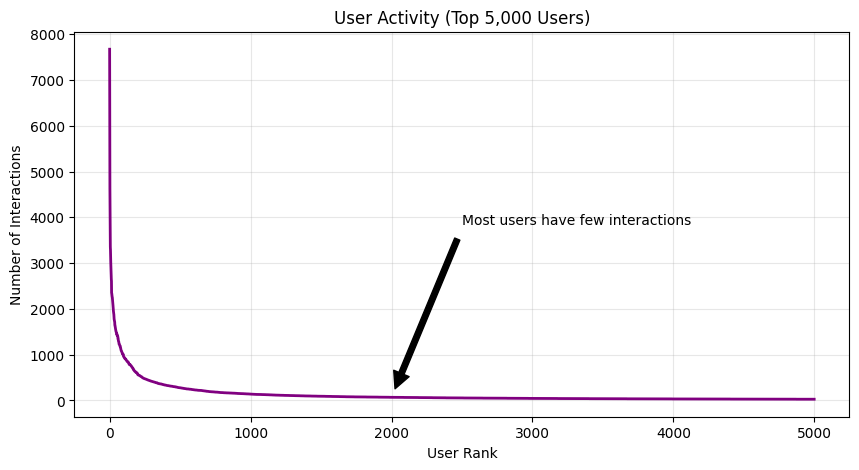

In [3]:
def plot_long_tail():

    user_activity = raw_inter_df['user_id'].value_counts().values

    plt.figure(figsize=(10, 5))
    plt.plot(user_activity[:5000], color='purple', linewidth=2)

    plt.title("User Activity (Top 5,000 Users)")
    plt.xlabel("User Rank")
    plt.ylabel("Number of Interactions")
    plt.grid(True, alpha=0.3)


    plt.annotate('Most users have few interactions', 
                 xy=(2000, user_activity[2000]), 
                 xytext=(2500, max(user_activity)/2),
                 arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()

plot_long_tail()


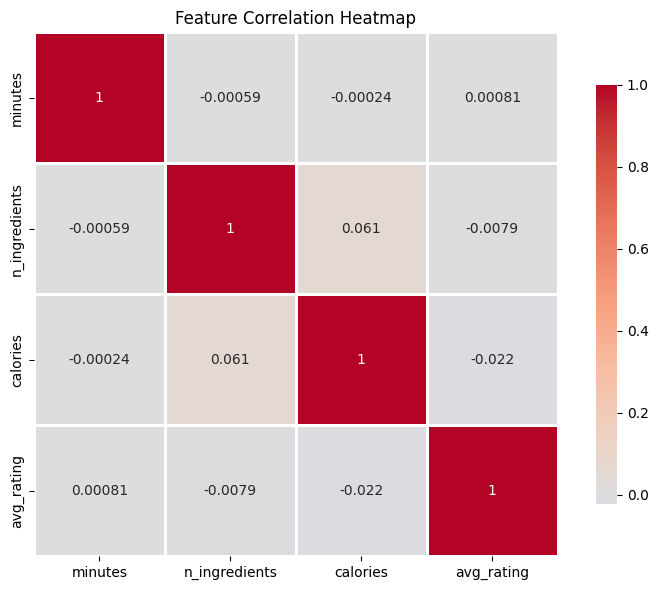

In [ ]:
# Correlation Heatmap

recipe_avg_rating = raw_inter_df.groupby('recipe_id')['rating'].mean().rename('avg_rating')


recipes_with_rating = raw_recipes_df.merge(recipe_avg_rating, left_on='id', right_index=True, how='left')

num_cols = ['minutes', 'n_ingredients', 'calories', 'avg_rating']

num_cols = [col for col in num_cols if col in recipes_with_rating.columns]

numerical_features = recipes_with_rating[num_cols].copy()

correlation_matrix = numerical_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


PART 2: MODELING PIPELINE

In [ ]:
train_df = pd.read_csv(base_path + "interactions_train.csv")
test_df = pd.read_csv(base_path + "interactions_test.csv")
pp_recipes = pd.read_csv(base_path + "PP_recipes.csv")

if "raw_recipes_df" not in locals():
    raw_recipes_df = pd.read_csv(base_path + "RAW_recipes.csv")
    raw_recipes_df["n_ingredients"] = raw_recipes_df["n_ingredients"].fillna(0)
    raw_recipes_df["minutes"] = raw_recipes_df["minutes"].fillna(0)
    raw_recipes_df["calories"] = raw_recipes_df["nutrition"].apply(
        lambda x: float(ast.literal_eval(x)[0]) if isinstance(x, str) else 0
    )

i_to_raw_id = pd.Series(pp_recipes.id.values, index=pp_recipes.i).to_dict()
pp_recipes["ingr_ids_list"] = pp_recipes["ingredient_ids"].apply(ast.literal_eval)
i_to_ingr_set = pd.Series(
    pp_recipes["ingr_ids_list"].values, index=pp_recipes.i
).to_dict()

raw_recipes_df["tags_list"] = raw_recipes_df["tags"].apply(
    lambda x: set(ast.literal_eval(x))
)
raw_id_to_tags = pd.Series(
    raw_recipes_df["tags_list"].values, index=raw_recipes_df["id"]
).to_dict()

## Load Official Splits & ID mappings

In [ ]:
raw_recipes_df["log_minutes"] = np.log1p(raw_recipes_df["minutes"])
raw_recipes_df["log_calories"] = np.log1p(raw_recipes_df["calories"])
raw_recipes_df["log_n_ingr"] = np.log1p(raw_recipes_df["n_ingredients"])

scaler = StandardScaler()
cols = ["log_minutes", "log_calories", "log_n_ingr"]
norm_feats = scaler.fit_transform(raw_recipes_df[cols])

raw_id_to_feats = {rid: norm_feats[idx] for idx, rid in enumerate(raw_recipes_df["id"]) }

item_content_feats = {}
item_tag_sets = {}
valid_items = []

for i, raw_id in i_to_raw_id.items():
    if raw_id in raw_id_to_feats:
        item_content_feats[i] = raw_id_to_feats[raw_id]
        valid_items.append(i)
    if raw_id in raw_id_to_tags:
        item_tag_sets[i] = raw_id_to_tags[raw_id]

item_counts = train_df["i"].value_counts().to_dict()

## Feature Normalization & Item Mapping

PART 3: TRAINING MODEL 

Building User Profiles

In [ ]:
user_centroids = {}
user_ingr_sets = defaultdict(set)
user_tag_sets = defaultdict(set)
user_sums = defaultdict(lambda: np.zeros(3))
user_cnts = defaultdict(int)

for _, row in train_df.iterrows():
    u = row["u"]
    i = row["i"]
    if i in item_content_feats:
        user_sums[u] += item_content_feats[i]
        user_cnts[u] += 1
    if i in i_to_ingr_set:
        user_ingr_sets[u].update(i_to_ingr_set[i])
    if i in item_tag_sets:
        user_tag_sets[u].update(item_tag_sets[i])

for u in user_sums:
    if user_cnts[u] > 0:
        user_centroids[u] = user_sums[u] / user_cnts[u]

## Generate Training Samples

In [ ]:

X_train = []
y_train = []
train_sample = train_df.sample(n=50000, random_state=42)

def get_content_vector(u, i):
    jaccard_ingr = 0.0
    if u in user_ingr_sets and i in i_to_ingr_set:
        u_s = user_ingr_sets[u]
        i_s = i_to_ingr_set[i]
        if u_s and i_s:
            jaccard_ingr = len(u_s.intersection(i_s)) / len(u_s.union(i_s))

    jaccard_tags = 0.0
    if u in user_tag_sets and i in item_tag_sets:
        u_t = user_tag_sets[u]
        i_t = item_tag_sets[i]
        if u_t and i_t:
            jaccard_tags = len(u_t.intersection(i_t)) / len(u_t.union(i_t))

    if u in user_centroids and i in item_content_feats:
        diff = np.abs(user_centroids[u] - item_content_feats[i])
    else:
        diff = np.array([0.0, 0.0, 0.0])

    return np.concatenate(([jaccard_ingr, jaccard_tags], diff))

for _, row in train_sample.iterrows():
    u = row["u"]
    pos_i = row["i"]
    if u not in user_centroids:
        continue
    X_train.append(get_content_vector(u, pos_i))
    y_train.append(1)
    neg_i = random.choice(valid_items)
    while neg_i == pos_i:
        neg_i = random.choice(valid_items)
    X_train.append(get_content_vector(u, neg_i))
    y_train.append(0)

## Fit Model

In [ ]:
# Fit Logistic Regression
model = LogisticRegression(class_weight="balanced", max_iter=1000, C=1.0)
model.fit(X_train, y_train)

weights = model.coef_[0]
print("--- Model Weights Interpretation ---")
print(f"Ingr Jaccard:   {weights[0]:.4f} (Positive = Users like shared ingredients)")
print(
    f"Tag Jaccard:    {weights[1]:.4f}) (Should be Positive, but the Users apparently appreciate variety??"
)
print(f"Time Diff:      {weights[2]:.4f} (Negative = Users dislike Time mismatch)")
print(f"Calorie Diff:   {weights[3]:.4f} (Negative = Users dislike Calorie mismatch)")
print(
    f"Complexity Diff:{weights[4]:.4f} (Negative = Users dislike Complexity mismatch)"
)

--- Model Weights Interpretation ---
Ingr Jaccard:   18.5512 (Positive = Users like shared ingredients)
Tag Jaccard:    -1.9314) (Should be Positive, but the Users apparently appreciate variety??
Time Diff:      -0.0413 (Negative = Users dislike Time mismatch)
Calorie Diff:   -0.1231 (Negative = Users dislike Calorie mismatch)
Complexity Diff:-0.1906 (Negative = Users dislike Complexity mismatch)


## EVALUATION

In [ ]:


sorted_items = sorted(item_counts, key=item_counts.get, reverse=True)
global_top_10 = set(sorted_items[:10])

import math
import random
from sklearn.metrics import roc_auc_score

def evaluate_all_metrics(test_data, limit=1000):
    total_users = 0
    sum_hr_model = 0.0
    sum_ndcg_model = 0.0
    sum_auc_model = 0.0
    sum_hr_pop = 0.0
    sum_ndcg_pop = 0.0
    sum_auc_pop = 0.0

    print(f"Evaluating on random subset of {limit} users...")
    print("Protocol: For each user, rank the True Item against 99 Random Decoys.")

    subset = test_data.sample(n=limit, random_state=42)

    for _, row in subset.iterrows():
        u = row["u"]
        true_item = row["i"]
        is_cold_start = u not in user_centroids
        candidates = [true_item]
        labels = [1]
        while len(candidates) < 100:
            decoy = random.choice(valid_items)
            if decoy != true_item:
                candidates.append(decoy)
                labels.append(0)

        model_scores = []
        pop_scores = []

        for item in candidates:
            if not is_cold_start:
                vec = get_content_vector(u, item).reshape(1, -1)
                score = model.predict_proba(vec)[0][1]
            else:
                score = item_counts.get(item, 0)
            model_scores.append(score)
            pop_scores.append(item_counts.get(item, 0))

        def calc_user_metrics(scores, current_labels):
            zipped = list(zip(scores, current_labels))
            zipped.sort(key=lambda x: x[0], reverse=True)
            rank = -1
            for r, (score, label) in enumerate(zipped):
                if label == 1:
                    rank = r + 1
                    break
            hr = 1 if rank <= 10 else 0
            ndcg = 1 / math.log2(rank + 1) if rank <= 10 else 0
            try:
                auc = roc_auc_score(current_labels, scores)
            except ValueError:
                auc = 0.5
            return hr, ndcg, auc

        m_hr, m_ndcg, m_auc = calc_user_metrics(model_scores, labels)
        sum_hr_model += m_hr
        sum_ndcg_model += m_ndcg
        sum_auc_model += m_auc

        p_hr, p_ndcg, p_auc = calc_user_metrics(pop_scores, labels)
        sum_hr_pop += p_hr
        sum_ndcg_pop += p_ndcg
        sum_auc_pop += p_auc

        total_users += 1

    return {
        "Model": {
            "HR@10": sum_hr_model / total_users,
            "NDCG@10": sum_ndcg_model / total_users,
            "AUC": sum_auc_model / total_users,
        },
        "Popularity": {
            "HR@10": sum_hr_pop / total_users,
            "NDCG@10": sum_ndcg_pop / total_users,
            "AUC": sum_auc_pop / total_users,
        },
    }

In [ ]:
results = evaluate_all_metrics(test_df, limit=1000)

print(f"\n--- FINAL RESULTS ---")
print(f"{'Metric':<10} | {'Popularity':<10} | {'Our Model':<10}")
print("-" * 35)
print(
    f"{'HR@10':<10} | {results['Popularity']['HR@10']:.4f}     | {results['Model']['HR@10']:.4f}"
)
print(
    f"{'NDCG@10':<10} | {results['Popularity']['NDCG@10']:.4f}     | {results['Model']['NDCG@10']:.4f}"
)
print(
    f"{'AUC':<10}   | {results['Popularity']['AUC']:.4f}     | {results['Model']['AUC']:.4f}"
)

Evaluating on random subset of 1000 users...
Protocol: For each user, rank the True Item against 99 Random Decoys.

--- FINAL RESULTS ---
Metric     | Popularity | Our Model 
-----------------------------------
HR@10      | 0.0000     | 0.1590
NDCG@10    | 0.0000     | 0.0720
AUC          | 0.0489     | 0.5693

--- FINAL RESULTS ---
Metric     | Popularity | Our Model 
-----------------------------------
HR@10      | 0.0000     | 0.1590
NDCG@10    | 0.0000     | 0.0720
AUC          | 0.0489     | 0.5693


# VISUALIZATION OF RESULTS

Generating Hit Rate Curve (this takes a moment)...


Generating Hit Rate Curve (this takes a moment)...


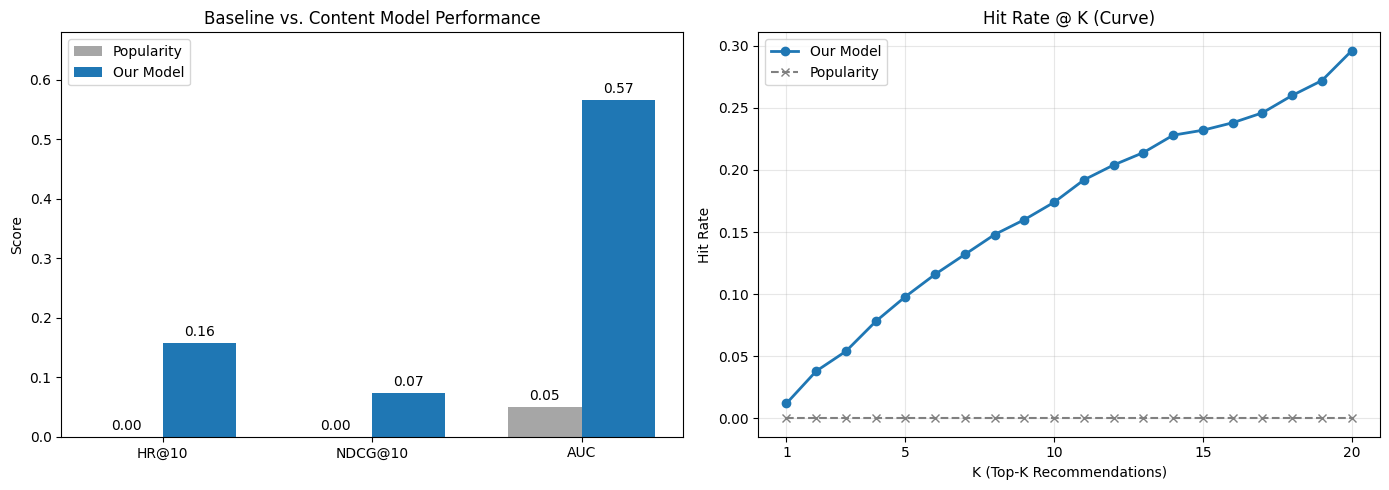

In [ ]:

import matplotlib.pyplot as plt

def plot_final_metrics(results):
    metrics = ["HR@10", "NDCG@10", "AUC"]
    pop_vals = [results["Popularity"][m] for m in metrics]
    model_vals = [results["Model"][m] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    plt.figure(figsize=(14, 5))

    ax1 = plt.subplot(1, 2, 1)
    rects1 = ax1.bar(x - width / 2, pop_vals, width, label="Popularity", color="gray", alpha=0.7)
    rects2 = ax1.bar(x + width / 2, model_vals, width, label="Our Model", color="#1f77b4")

    ax1.set_ylabel("Score")
    ax1.set_title("Baseline vs. Content Model Performance")
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.legend()
    ax1.set_ylim(0, max(model_vals) * 1.2)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax1.annotate(f"{height:.2f}",
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha="center", va="bottom")
    autolabel(rects1)
    autolabel(rects2)

    print("Generating Hit Rate Curve (this takes a moment)...")

    def get_raw_ranks(limit=500):
        ranks_m = []
        ranks_p = []
        subset = test_df.sample(n=limit, random_state=42)
        for _, row in subset.iterrows():
            u, true_item = row["u"], row["i"]
            is_cold = u not in user_centroids
            candidates = [true_item]
            while len(candidates) < 100:
                decoy = random.choice(valid_items)
                if decoy != true_item:
                    candidates.append(decoy)

            m_scores = []
            p_scores = []
            for item in candidates:
                if not is_cold:
                    vec = get_content_vector(u, item).reshape(1, -1)
                    m_scores.append(model.predict_proba(vec)[0][1])
                else:
                    m_scores.append(item_counts.get(item, 0))
                p_scores.append(item_counts.get(item, 0))

            zipped_m = sorted(zip(m_scores, range(100)), key=lambda x: x[0], reverse=True)
            for rank, (score, idx) in enumerate(zipped_m):
                if idx == 0:
                    ranks_m.append(rank + 1)
                    break

            zipped_p = sorted(zip(p_scores, range(100)), key=lambda x: x[0], reverse=True)
            for rank, (score, idx) in enumerate(zipped_p):
                if idx == 0:
                    ranks_p.append(rank + 1)
                    break
        return ranks_m, ranks_p

    raw_ranks_model, raw_ranks_pop = get_raw_ranks(limit=500)

    k_values = range(1, 21)
    hr_curve_m = [sum(1 for r in raw_ranks_model if r <= k)/len(raw_ranks_model) for k in k_values]
    hr_curve_p = [sum(1 for r in raw_ranks_pop if r <= k)/len(raw_ranks_pop) for k in k_values]

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(k_values, hr_curve_m, marker="o", linewidth=2, label="Our Model")
    ax2.plot(k_values, hr_curve_p, marker="x", linestyle="--", color="gray", label="Popularity")

    ax2.set_xlabel("K (Top-K Recommendations)")
    ax2.set_ylabel("Hit Rate")
    ax2.set_title("Hit Rate @ K (Curve)")
    ax2.set_xticks([1, 5, 10, 15, 20])
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_final_metrics(results)

In [ ]:
def show_most_popular_items(top_n=20):
    print(f"--- TOP {top_n} MOST POPULAR RECIPES (BASELINE) ---")
    print("Building ID maps...")

    df_raw = raw_recipes_df
    local_i_to_raw = pd.Series(pp_recipes["id"].values, index=pp_recipes["i"]).to_dict()
    local_raw_to_name = pd.Series(df_raw["name"].values, index=df_raw["id"]).to_dict()

    top_items = train_df["i"].value_counts().head(top_n)

    print(f"\n{'Rank':<5} | {'Count':<8} | {'Recipe Name'}")
    print("-" * 65)

    for rank, (i, count) in enumerate(top_items.items()):
        if i in local_i_to_raw:
            raw_id = local_i_to_raw[i]
            name = local_raw_to_name.get(raw_id, "Unknown Name")
            if isinstance(name, str) and len(name) > 45:
                name = name[:42] + "..."
            print(f"#{rank+1:<4} | {count:<8} | {name}")
        else:
            print(f"#{rank+1:<4} | {count:<8} | [ID {i} not found]")

top_items = train_df["i"].value_counts().head(20)
show_most_popular_items(20)

--- TOP 20 MOST POPULAR RECIPES (BASELINE) ---
Building ID maps...

Rank  | Count    | Recipe Name
-----------------------------------------------------------------
#1    | 1091     | to die for crock pot roast
#2    | 1075     | crock pot chicken with black beans   cream...
#3    | 897      | whatever floats your boat  brownies
#4    | 894      | creamy cajun chicken pasta
#5    | 787      | kittencal s italian melt in your mouth mea...
#6    | 758      | yes  virginia there is a great meatloaf
#7    | 738      | jo mama s world famous spaghetti
#8    | 681      | japanese mum s chicken
#9    | 677      | banana banana bread
#10   | 666      | oven fried chicken chimichangas
#11   | 655      | kittencal s moist cheddar garlic oven frie...
#12   | 629      | creamy burrito casserole
#13   | 625      | best ever banana cake with cream cheese fr...
#14   | 570      | my family s favorite sloppy joes  pizza joes
#15   | 546      | kittencal s 5 minute cinnamon flop brunch ...
#16   | 523 

In [ ]:
def show_popularity_dropoff(top_n=20):
    print(f"\n--- POPULARITY DROPOFF ANALYSIS (Top {top_n} Train Items) ---")

    top_train_items = pd.Series(item_counts).sort_values(ascending=False).head(top_n)
    test_counts_series = test_df["i"].value_counts()
    raw_id_to_name = pd.Series(
        raw_recipes_df["name"].values, index=raw_recipes_df["id"]
    ).to_dict()

    print(
        f"{'Rank':<5} | {'Recipe Name (Train Leader)':<40} | {'Train Reviews':<12} | {'Test Reviews'}"
    )
    print("-" * 85)

    for rank, (i, train_count) in enumerate(top_train_items.items()):
        test_count = test_counts_series.get(i, 0)
        if i in i_to_raw_id:
            raw_id = i_to_raw_id[i]
            name = raw_id_to_name.get(raw_id, "Unknown Name")
            if len(name) > 30:
                name = name[:25] + "..."
        else:
            name = f"ID {i}"
        alert = " <--- zero times!" if test_count == 0 else ""
        print(f"#{rank+1:<4} | {name:<40} | {train_count:<12} | {test_count}{alert}")

show_popularity_dropoff(20)


--- POPULARITY DROPOFF ANALYSIS (Top 20 Train Items) ---
Rank  | Recipe Name (Train Leader)               | Train Reviews | Test Reviews
-------------------------------------------------------------------------------------
#1    | to die for crock pot roast               | 1091         | 0 <--- zero times!
#2    | crock pot chicken with bl...             | 1075         | 0 <--- zero times!
#3    | whatever floats your boat...             | 897          | 0 <--- zero times!
#4    | creamy cajun chicken pasta               | 894          | 0 <--- zero times!
#5    | kittencal s italian melt ...             | 787          | 0 <--- zero times!
#6    | yes  virginia there is a ...             | 758          | 0 <--- zero times!
#7    | jo mama s world famous sp...             | 738          | 0 <--- zero times!
#8    | japanese mum s chicken                   | 681          | 0 <--- zero times!
#9    | banana banana bread                      | 677          | 0 <--- zero times!
#10   | ove